# Demographic filtering (with KNN)

Import packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, cdist, jaccard
from sklearn.preprocessing import MinMaxScaler

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Load data

In [2]:
dtrain = pd.read_csv('Data/dtrain_cleaned.csv')
dtest = pd.read_csv('Data/dtest_cleaned.csv')

In [3]:
dtrain.describe()

,Unnamed: 0,AktorId,Alder,FylkeNr,KommuneNr,Postnr,ErDisponentAnt,ErKontoapnerAnt,ErKausjonistAnt,ErRealkausjonistAnt,...,AntSparekonto,AntAktiveSkadefors,AntAktiv_AndreForsikringer,AntAktUtlanAvt,AntAvtBSU,AntAktBoliglan,DNBAntAktBoliglan,AntAktGaranterte,AntAktLink,AntAktSpareforsikring
count,3630.000000,3.630000e+03,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,...,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,2508.213774,3.218082e+06,43.208815,7.695868,783.614325,3613.719008,0.300551,0.055923,0.000551,0.014601,...,0.701653,0.102479,0.102204,0.178512,0.107713,0.176584,0.045455,0.044077,0.011846,0.201377
std,1431.680916,2.104151e+06,14.468157,5.738833,576.161533,2556.014909,0.458561,0.229804,0.023469,0.119964,...,0.457596,0.303319,0.302958,0.382996,0.310061,0.381369,0.208328,0.205295,0.108206,0.401085
min,0.000000,9.380000e+02,18.000000,1.000000,101.000000,168.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1284.500000,1.548604e+06,31.000000,3.000000,301.000000,1453.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2512.500000,2.712668e+06,43.000000,6.000000,621.500000,3124.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3731.500000,4.479664e+06,55.000000,12.000000,1201.000000,5229.750000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4998.000000,9.424479e+06,70.000000,20.000000,2030.000000,9990.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Remove unnamed

In [4]:
dtrain = dtrain.drop('Unnamed: 0', 1)
dtest = dtest.drop('Unnamed: 0', 1)

Define ID and target variables

In [5]:
ID_col = 'AktorId'
target_cols = ['AntAktAvtBank',
 'AntAktAvtInnskudd',
 'AntAktAvtKredittkort',
 'AntKredittkortDebet',
 'AntKredittkortKreditt',
 'AntSparekonto',
 'AntBrukskonto',
 'AntAvtBSU',
 'AntAktiveSkadefors',
 'AntAktiv_AndreForsikringer',
 'AntAktSpareforsikring',
 'AntAktUtlanAvt',
 'AntAktBoliglan',
 'DNBAntAktBoliglan',
 'AntAktGaranterte',
 'AntAktLink']

demo_cols = [x for x in dtrain.columns if x not in ID_col]
demo_cols = [x for x in demo_cols if x not in target_cols]

Create train and test set with demographic variables and target variables

In [6]:
dtrain_id = dtrain['AktorId']
dtest_id = dtest['AktorId']
dtrain_matrix = dtrain[[col for col in demo_cols]]
dtest_matrix = dtest[[col for col in demo_cols]]
dtrain_target = dtrain[[col for col in target_cols]]
dtest_target = dtest[[col for col in target_cols]]

Normalize data in train and test matrix

In [7]:
scaler_train = MinMaxScaler(feature_range=(0,1))
scaler_train = scaler_train.fit(dtrain_matrix)
dtrain_matrix = scaler_train.transform(dtrain_matrix)

scaler_test = MinMaxScaler(feature_range=(0,1))
scaler_test = scaler_test.fit(dtest_matrix)
dtest_matrix = scaler_test.transform(dtest_matrix)

In [8]:
print(dtest_matrix)

[[  2.11538462e-01   1.00000000e-01   9.95024876e-02 ...,   8.61074059e-03
    2.63814913e-02   5.00000000e-01]
 [  2.11538462e-01   1.00000000e-01   9.95024876e-02 ...,   4.35192122e-03
    5.53428762e-03   3.75000000e-01]
 [  1.15384615e-01   1.00000000e-01   9.95024876e-02 ...,   2.67313796e-03
    3.20822237e-02   3.75000000e-01]
 ..., 
 [  3.26923077e-01   5.00000000e-02   5.87064677e-02 ...,   2.97710106e-03
    2.07431758e-01   3.75000000e-01]
 [  2.88461538e-01   5.50000000e-01   5.70149254e-01 ...,   2.74472435e-04
    3.30933755e-01   1.25000000e-01]
 [  1.92307692e-02   5.00000000e-02   5.87064677e-02 ...,   6.59620358e-03
    2.46754328e-01   3.75000000e-01]]


Calculate Pearson similarity for train set

In [9]:
def similarity_train(dtrain_matrix):
    t0 = time.time()
    similarity_train = squareform(1-pdist(dtrain_matrix,'correlation'))
    t1 = time.time()
    time_sim_train = t1-t0
    print('Similarity time train %.4g' % time_sim_train)
    return time_sim_train,similarity_train

In [10]:
time_sim_train,similarity_train = similarity_train(dtrain_matrix)

Similarity time train 0.7308


In [11]:
similarity_train

array([[ 0.        ,  0.06878092,  0.46697654, ...,  0.9241484 ,
         0.51291044,  0.44818671],
       [ 0.06878092,  0.        ,  0.5358358 , ...,  0.28336248,
         0.5210478 ,  0.54777229],
       [ 0.46697654,  0.5358358 ,  0.        , ...,  0.75371603,
         0.98734019,  0.94649264],
       ..., 
       [ 0.9241484 ,  0.28336248,  0.75371603, ...,  0.        ,
         0.76878899,  0.75313883],
       [ 0.51291044,  0.5210478 ,  0.98734019, ...,  0.76878899,
         0.        ,  0.90145393],
       [ 0.44818671,  0.54777229,  0.94649264, ...,  0.75313883,
         0.90145393,  0.        ]])

Prediction function selecting the neighbors from the similarity measure

In [12]:
def prediction(target,sim,n_nbrs):
    t0 = time.time()
    n_nbrs = n_nbrs
    n_users=len(sim)
    n_items=len(target.columns)
    pred=np.zeros((n_users,n_items))
    for u in range (n_users):
        nbrs_indices = [j[0] for j in sorted(enumerate(sim[u,:]),key=lambda x:x[1],reverse=True)[:n_nbrs]]
        vote_1=0
        vote_2=0
        for i in range (n_items):
            for n in nbrs_indices: 
                vote_1 += target.values[n,i]*sim[u,n]
                vote_2 += (1-target.values[n,i])*sim[u,n]
            if(vote_1>vote_2):
                pred[u,i]=1
    t1 = time.time()
    time_pred = t1-t0
    print('Prediction time %.4g' % time_pred)
    return time_pred,n_nbrs,pred

Function calculating prediction accuracy

In [13]:
def accuracy(target,pred,n_nbrs,reports=False):
    print('\nModel Report: k =',n_nbrs,'\n')
    i=0
    accuracy_lst=[]
    for col in target.columns:
        accuracy = metrics.accuracy_score(target.values[:,i],pred[:,i])
        accuracy_lst.append(accuracy)
        print (col,'%.4g' % accuracy)
        if(reports==True):
            report = classification_report(target.values[:,i],pred[:,i])
            print(report)
            cm = confusion_matrix(target.values[:,i],pred[:,i])
            print(cm)
        i+=1
    avg_accuracy = np.average(accuracy_lst)
    print('\nAverage accuracy %.4g' % avg_accuracy)
    return accuracy_lst, avg_accuracy

Parameter tuning: tune number of neighbors

In [14]:
k_accuracy=[]
k_time=[]
tot_nbrs = 25
for i in range (5,tot_nbrs+1):
    time_pred_train,n_nbrs,pred_train = prediction(dtrain_target,similarity_train,i)
    accuracy_train,avg_accuracy_train = accuracy(dtrain_target,pred_train,n_nbrs)
    k_accuracy.append(avg_accuracy_train)
    k_time.append(time_pred_train)

Prediction time 42.63

Model Report: k = 5 

AntAktAvtBank 0.8898
AntAktAvtInnskudd 0.9242
AntAktAvtKredittkort 0.6149
AntKredittkortDebet 0.468
AntKredittkortKreditt 0.4256
AntSparekonto 0.7565
AntBrukskonto 0.8322
AntAvtBSU 0.4758
AntAktiveSkadefors 0.5413
AntAktiv_AndreForsikringer 0.6424
AntAktSpareforsikring 0.6518
AntAktUtlanAvt 0.8647
AntAktBoliglan 0.9063
DNBAntAktBoliglan 0.8667
AntAktGaranterte 0.8584
AntAktLink 0.8948

Average accuracy 0.7258
Prediction time 44.11

Model Report: k = 6 

AntAktAvtBank 0.8912
AntAktAvtInnskudd 0.9248
AntAktAvtKredittkort 0.6124
AntKredittkortDebet 0.4606
AntKredittkortKreditt 0.4229
AntSparekonto 0.7579
AntBrukskonto 0.8358
AntAvtBSU 0.4738
AntAktiveSkadefors 0.5369
AntAktiv_AndreForsikringer 0.6383
AntAktSpareforsikring 0.6504
AntAktUtlanAvt 0.873
AntAktBoliglan 0.9083
DNBAntAktBoliglan 0.8686
AntAktGaranterte 0.8556
AntAktLink 0.8972

Average accuracy 0.7255
Prediction time 51.76

Model Report: k = 7 

AntAktAvtBank 0.8948
AntAktAvtInnskudd 

Plot the accuracy for different K values

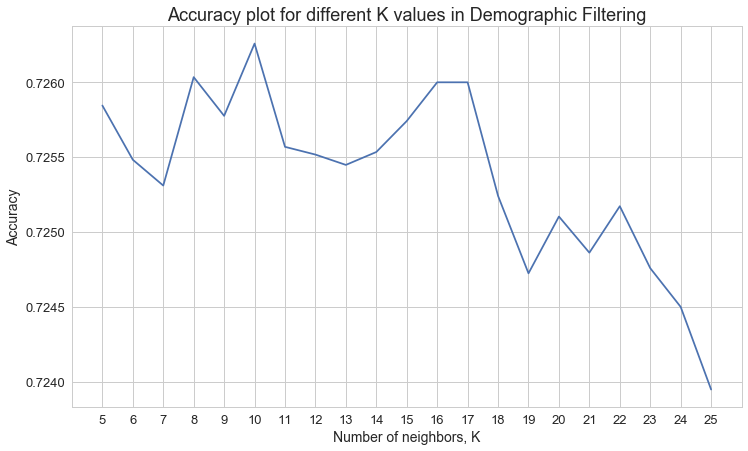

In [15]:
k_indices=np.array([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
k_indices.astype(int)
    
with sns.plotting_context("notebook",font_scale=1.3):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,7))
    plt.plot(k_indices,k_accuracy);
    plt.xticks(k_indices, k_indices)
    plt.title('Accuracy plot for different K values in Demographic Filtering',fontsize=18)
    plt.xlabel('Number of neighbors, K',fontsize=14)
    plt.ylabel('Accuracy',fontsize=14)
    plt.savefig('demographic_acc')
    plt.show()
    plt.close()

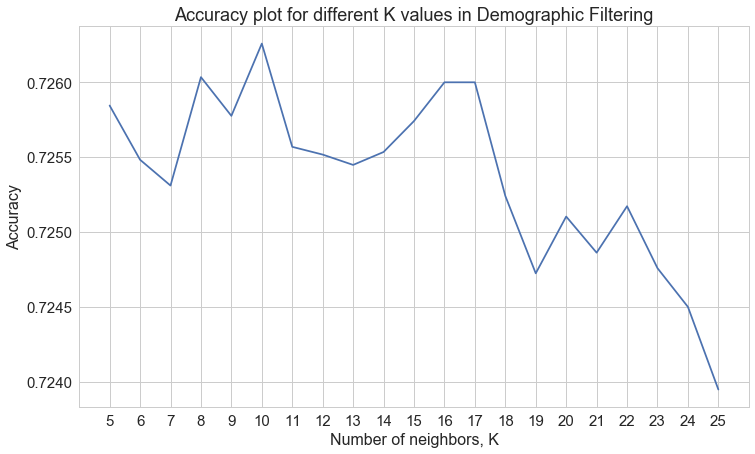

In [35]:
k_indices=np.array([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
k_indices.astype(int)
    
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,7))
    plt.plot(k_indices,k_accuracy);
    plt.xticks(k_indices, k_indices)
    plt.title('Accuracy plot for different K values in Demographic Filtering',fontsize=18)
    plt.xlabel('Number of neighbors, K',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.savefig('demographic_acc_2')
    plt.show()
    plt.close()

Plot the running time for different K values

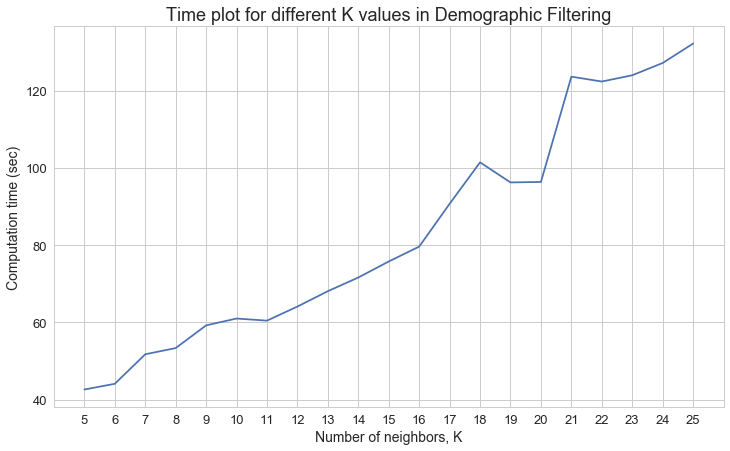

In [37]:
with sns.plotting_context("notebook",font_scale=1.3):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,7))
    plt.plot(k_indices,k_time);
    plt.xticks(k_indices, k_indices)
    plt.title('Time plot for different K values in Demographic Filtering',fontsize=18)
    plt.xlabel('Number of neighbors, K',fontsize=14)
    plt.ylabel('Computation time (sec)',fontsize=14)
    plt.savefig('demographic_time')
    plt.show()
    plt.close()

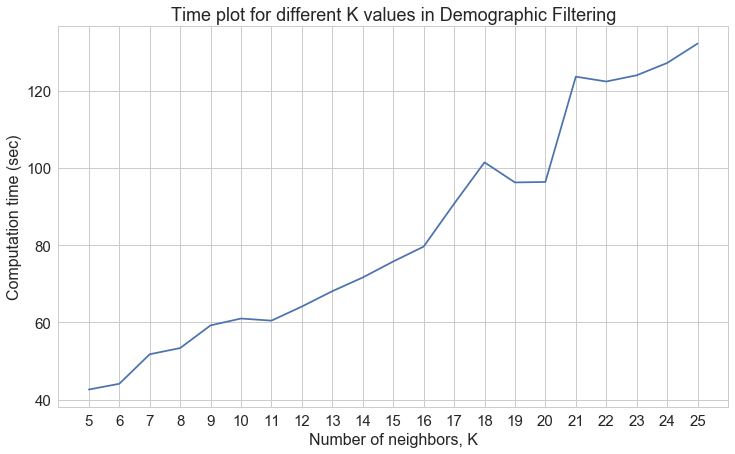

In [38]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,7))
    plt.plot(k_indices,k_time);
    plt.xticks(k_indices, k_indices)
    plt.title('Time plot for different K values in Demographic Filtering',fontsize=18)
    plt.xlabel('Number of neighbors, K',fontsize=16)
    plt.ylabel('Computation time (sec)',fontsize=16)
    plt.savefig('demographic_time_2')
    plt.show()
    plt.close()

Predict items for train set with k=10

In [17]:
opt_n_nbrs = k_accuracy.index(max(k_accuracy))+5
time_pred_train,opt_n_nbrs,pred_train = prediction(dtrain_target,similarity_train,opt_n_nbrs)

Prediction time 70.88


Calculate the accuracy for the train set

In [18]:
accuracy_train,avg_accuracy_train = accuracy(dtrain_target,pred_train,opt_n_nbrs,reports=True)


Model Report: k = 10 

AntAktAvtBank 0.8975
             precision    recall  f1-score   support

          0       0.54      0.18      0.27       383
          1       0.91      0.98      0.94      3247

avg / total       0.87      0.90      0.87      3630

[[  70  313]
 [  59 3188]]
AntAktAvtInnskudd 0.9259
             precision    recall  f1-score   support

          0       0.54      0.21      0.30       277
          1       0.94      0.99      0.96      3353

avg / total       0.91      0.93      0.91      3630

[[  57  220]
 [  49 3304]]
AntAktAvtKredittkort 0.6124
             precision    recall  f1-score   support

          0       0.59      0.06      0.11      1434
          1       0.61      0.97      0.75      2196

avg / total       0.60      0.61      0.50      3630

[[  89 1345]
 [  62 2134]]
AntKredittkortDebet 0.4463
             precision    recall  f1-score   support

          0       0.99      0.26      0.42      2726
          1       0.31      0.99      0.47

Calculate Pearson similarity for test set

In [19]:
def similarity_test(dtrain_matrix,dtest_matrix):
    t0 = time.time()
    similarity_test = (1-cdist(dtest_matrix,dtrain_matrix,'correlation'))
    t1 = time.time()
    time_sim_test = t1-t0
    print('Similarity time test %.4g' % time_sim_test)
    return time_sim_test,similarity_test

In [20]:
time_sim_test,similarity_test = similarity_test(dtrain_matrix,dtest_matrix)

Similarity time test 0.2956


Predict items for test set

In [21]:
time_pred_test,opt_n_nbrs,pred_test = prediction(dtrain_target,similarity_test,opt_n_nbrs)

Prediction time 25.64


Calculate the accuracy for the test set

In [22]:
accuracy_test,avg_accuracy_test = accuracy(dtest_target,pred_test,opt_n_nbrs,reports=True)


Model Report: k = 10 

AntAktAvtBank 0.9017
             precision    recall  f1-score   support

          0       0.61      0.16      0.25       126
          1       0.91      0.99      0.95      1084

avg / total       0.88      0.90      0.87      1210

[[  20  106]
 [  13 1071]]
AntAktAvtInnskudd 0.9339
             precision    recall  f1-score   support

          0       0.60      0.18      0.27        85
          1       0.94      0.99      0.97      1125

avg / total       0.92      0.93      0.92      1210

[[  15   70]
 [  10 1115]]
AntAktAvtKredittkort 0.6124
             precision    recall  f1-score   support

          0       0.61      0.04      0.08       476
          1       0.61      0.98      0.75       734

avg / total       0.61      0.61      0.49      1210

[[ 20 456]
 [ 13 721]]
AntKredittkortDebet 0.4008
             precision    recall  f1-score   support

          0       1.00      0.23      0.37       937
          1       0.27      1.00      0.43    

### Save result files

Save predictions to csv

In [23]:
pred_train_file=pd.DataFrame(pred_train)
pred_test_file=pd.DataFrame(pred_test)

In [24]:
pred_train_file.to_csv('Results/Demographic_predictions_train.csv',index=False)
pred_test_file.to_csv('Results/Demographic_predictions_test.csv',index=False)

Save true target values to csv

In [25]:
dtrain_target_file=pd.DataFrame(dtrain_target)
dtest_target_file=pd.DataFrame(dtest_target)

In [26]:
dtrain_target_file.to_csv('Results/Target_train.csv',index=False)
dtest_target_file.to_csv('Results/Target_test.csv',index=False)

Save train and test accuracies to csv

In [27]:
dtrain_accuracy_file=pd.DataFrame(accuracy_train)
dtest_accuracy_file=pd.DataFrame(accuracy_test)

In [28]:
dtrain_accuracy_file.to_csv('Results/Demographic_accuracy_train.csv',index=False)
dtest_accuracy_file.to_csv('Results/Demographic_accuracy_test.csv',index=False)

Save similarity matrices to csv

In [29]:
dtrain_similarity_file=pd.DataFrame(similarity_train)
dtest_similarity_file=pd.DataFrame(similarity_test)

In [30]:
dtrain_similarity_file.to_csv('Results/Demographic_similarity_train.csv',index=False)
dtest_similarity_file.to_csv('Results/Demographic_similarity_test.csv',index=False)